In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import networkx as nx
from networkx.algorithms.approximation import clique
from sklearn.linear_model import LinearRegression, Ridge

<h1> I. Read, clean and transform the data</h1><br>
    - load data.csv<br>
    - delete empty columns<br>
    - densify table by shrinking rows with same (id, date) to one row<br>
    - transform dataframe to collection of dataframes, each represent single feature matrix<br>
    - create valid mask with 1 when stock return availbale and np.nan when it is not<br>
    

In [2]:
df = pd.read_csv('data.csv')

In [3]:
df.head()

,id,date,all,head,body,all.90,head.90,body.90,all.365,head.365,...,am.head,am.body,am.all.90,am.head.90,am.body.90,am.all.365,am.head.365,am.body.365,r0,r1
0,IZt2wDiJ,2006-01-03,0.000000,0.0,NaN,0.000000,0.0,NaN,0.000000,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.013643,0.013232
1,IZt2wDiJ,2006-01-03,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.013643,0.013232
2,IZt2wDiJ,2006-01-17,0.000000,NaN,0.0,0.000000,NaN,0.0,0.000000,NaN,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,-0.011081,0.037319
3,IZt2wDiJ,2006-01-19,0.000000,NaN,0.0,0.000000,NaN,0.0,0.000000,NaN,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,-0.020360,-0.016391
4,IZt2wDiJ,2006-01-26,-0.257143,-0.9,NaN,-0.257143,-0.9,NaN,-0.257143,-0.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.021940,0.015213


In [4]:
# Delete empty columns
for key in sorted(df.columns):
    if df[key].nunique()==0:
        del df[key]
        print(f'Column {key} was deleted')

Column am.all was deleted
Column am.all.365 was deleted
Column am.all.90 was deleted
Column am.body.365 was deleted
Column am.body.90 was deleted
Column am.head was deleted
Column am.head.365 was deleted
Column am.head.90 was deleted


In [5]:
# Desify rows with the same (id, date) to only one column, choose MAX value from each column
df_dense = df.groupby(['id', 'date']).max().reset_index()

In [6]:
df_dense.head()

,id,date,all,head,body,all.90,head.90,body.90,all.365,head.365,...,e.body,e.all.90,e.head.90,e.body.90,e.all.365,e.head.365,e.body.365,am.body,r0,r1
0,02Fm4cL2,2016-10-25,0.000000,NaN,0.000000,0.000000,NaN,0.000,0.000000,NaN,...,0.000000,0.000000,NaN,0.000,0.000000,NaN,0.000,0.000000,-0.001959,-0.004297
1,02Fm4cL2,2016-11-10,0.136667,0.076364,0.187692,0.294286,0.28,0.305,0.294286,0.280,...,0.187692,0.294286,0.28,0.305,0.294286,0.28,0.305,0.187692,0.043383,0.033375
2,02Fm4cL2,2016-11-11,0.305000,0.610000,0.000000,NaN,NaN,NaN,NaN,NaN,...,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.033375,-0.051493
3,04PgLfIfF,2006-01-10,-0.580000,-0.580000,NaN,-0.580000,-0.58,NaN,-0.580000,-0.580,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001676,-0.000362
4,04PgLfIfF,2006-01-11,0.444286,0.534000,0.220000,0.540000,0.54,NaN,0.535000,0.535,...,0.220000,NaN,NaN,NaN,NaN,NaN,NaN,0.220000,-0.000362,0.002038


In [7]:
# Transform dataframe to collection (dictionary) of single-feature matrices
features = set(df_dense.columns).difference(('id', 'date'))
data = {}
for feature in features:
    data[feature] = df_dense.pivot(index = "date", columns = "id", values = feature)

In [8]:
data['r1'].head()

id,02Fm4cL2,04PgLfIfF,06j8eVIBkycLI,07EoFzFHCa,07t20l4sGEixE,0A7BA2NOoiIJw,0BdYkQQES,0FG2q3p57mBB0,0G8d1WnAs,0Iqrw6qOS,...,zcLQHLcvfEyi6,zcafR7Xnt,zdKEd0aokE,zkETH3hUPaL31,zo3WzLC07X,zuBl60Jxd0,zwaZqRm1v,zww1CpUgEGjLd,zyzdUsXY1D,zzFZ1MFS4HboR
date,,,,,,,,,,,,,,,,,,,,,
2006-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-01-05,NaN,NaN,NaN,0.0287,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-01-06,NaN,NaN,0.018288,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-01-09,NaN,NaN,0.035561,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0308,NaN,0.003501,NaN,NaN,NaN,NaN,NaN,NaN


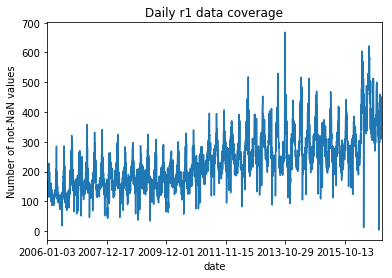

In [9]:
# Daily returns r1 coverage
data['r1'].notna().sum(axis=1).plot()
plt.title('Daily r1 data coverage')
plt.ylabel('Number of not-NaN values')
plt.show()

In [10]:
# Binary valid mask
vm = data['r1'].notna().replace([False], np.nan).replace([True], 1)

In [11]:
vm.head()

id,02Fm4cL2,04PgLfIfF,06j8eVIBkycLI,07EoFzFHCa,07t20l4sGEixE,0A7BA2NOoiIJw,0BdYkQQES,0FG2q3p57mBB0,0G8d1WnAs,0Iqrw6qOS,...,zcLQHLcvfEyi6,zcafR7Xnt,zdKEd0aokE,zkETH3hUPaL31,zo3WzLC07X,zuBl60Jxd0,zwaZqRm1v,zww1CpUgEGjLd,zyzdUsXY1D,zzFZ1MFS4HboR
date,,,,,,,,,,,,,,,,,,,,,
2006-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-01-05,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-01-06,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-01-09,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN


<h1>II. Generate alphas</h1><br>

Lets load collection of operators and alpha functions from  <i>operators.py</i> and <i>alphas.py</i>.<br>

- <i>operators.py</i> contains Operators - functions that get data and somehow transorm it (e.g. ts_mean(data, window) applies  moving average) <br><br>
- <i>alphas.py</i> contains Alpha patterns - functions that get data, apply some combination of operators and return dataframe with portfolio positions<br>

<hr>
Example of alpha pattern:<br>

<b>def</b> alpha_9(data, N=252):<br> 
&emsp; <b>return</b> market_normalize(market_neutralize(validate(ts_zscore(ts_ffill(data), N), vm))) <br>
<br>
This alpha:
- gets dataframe with some feature as an input
- forward-fills it (replaces NaNs with previous not-NaNs values)
- applies time-series zscore with rolling window = N
- multiplies it to valid mask
- neutralizes it (makes daily positions dollar-neutral)
- normalizes it (makes sum of absolute positions equal 1) 


In [12]:
from operators import *
from alphas import *

Now lets simulate all combinations of features and alpha patterns we have (excluding 'r0' and 'r1') and save generated postions and portfolio PnLs as csv files.<br>

- Alpha patterns get as an input one or two features. <br>

- For one input alphas we just simulate all combinations of (feature, alpha)<br>
- For two input alphas we simulate all combinations of alphas with all pairs of features<br>
- In summary, there are about 2000 alphas, so it takes time to simulate all of them<br>

To calcute daily PnL we find dot product of positions vectors with tomorrow returns vectors

\begin{equation*}
\mathbf{PNL}_t  = \sum_{i=1}^{M}position_{t, i} * return_{t+1, i}
\end{equation*}
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;<i>where t - day index; M - number of instruments in portfolio

In [13]:
def get_pnl(alpha_pos):
    '''Generate alpha PnL from alpha positions'''
    return (alpha_pos * data['r1']).sum(axis = 1)

In [14]:
pos_path = 'alpha_pos/'
pnl_path = 'alpha_pnl/'

In [15]:
# List of single input alphas
alpha_list = [alpha_1, alpha_2, alpha_3, alpha_4, alpha_5, alpha_6, alpha_7, alpha_8, 
              alpha_9, alpha_10, alpha_11, alpha_12, alpha_13, alpha_14, alpha_15, alpha_16, alpha_17, alpha_18]

In [ ]:
# Simulate all combinations of features and alphas and save positions and portfolio PnLs
# (DO NOT RUN, ALREADY SIMULATED)
for feature in features.difference(('r1', 'r0')):
    for alpha in alpha_list:
        file_name = alpha.__name__ + feature + '.csv'
        if os.path.exists(pos_path + file_name):
            print(file_name + ' was already simualted')
            continue
        positions = alpha(data[feature])
        pnl = get_pnl(positions)
        positions.to_csv(pos_path + file_name)
        pnl.to_csv(pnl_path + file_name)    

In [17]:
# List of two inputs alphas
alpha_list_2 = [alpha_19, alpha_20, alpha_21, alpha_22]

In [ ]:
# Simulate all combinations of all pairs of features and alphas and save positions and portfolio PnLs
# (DO NOT RUN, ALREADY SIMULATED)
for feature1 in features.difference(('r1', 'r0')):
    for feature2 in features.difference(('r1', 'r0')):
        if feature1 < feature2:
            for alpha in alpha_list_2:
                file_name = alpha.__name__ + '.' + feature1 + '.' +feature2 + '.csv'
                if os.path.exists(pos_path + file_name):
                    print(file_name + ' was already simualted')
                    continue
                positions = alpha(data[feature1], data[feature2])
                pnl = get_pnl(positions)
                positions.to_csv('alpha_pos/'+file_name)
                pnl.to_csv('alpha_pnl/'+file_name)    

Now  load all PnLs to dataframe <i>df_pnl

In [19]:
pnl_files = [f for f in os.listdir(pnl_path) if f.endswith('.csv')]
pnl_list  = []
for pnl in pnl_files:
    pnl_list.append(pd.read_csv('alpha_pnl/'+pnl, header = None, names=['date', pnl[:-4]]).set_index('date'))
df_pnl = pd.concat(pnl_list, axis = 1)

In [20]:
df_pnl.tail()

,alpha_10a.all.365,alpha_10a.all.90,alpha_10a.all,alpha_10a.body.365,alpha_10a.body.90,alpha_10a.body,alpha_10a.head,alpha_10all.365,alpha_10all.90,alpha_10all,...,alpha_9e.body.90,alpha_9e.body,alpha_9e.head.365,alpha_9e.head.90,alpha_9e.head,alpha_9h.head.365,alpha_9h.head.90,alpha_9head.365,alpha_9head.90,alpha_9head
date,,,,,,,,,,,,,,,,,,,,,
2016-12-23,-0.000681,-0.000517,0.000094,-0.000585,-0.000570,0.000239,-0.000323,-0.000240,-5.597653e-04,0.000387,...,0.000403,0.000839,0.000194,0.000713,0.001042,-0.000159,-0.000045,-0.000049,-0.000231,-0.000105
2016-12-27,0.001053,0.000750,0.001109,0.000034,0.000230,-0.000909,0.001225,-0.000177,-4.358535e-07,-0.001330,...,0.000950,-0.000750,0.000826,0.001272,0.000948,-0.000727,-0.000194,-0.000057,-0.000271,-0.000801
2016-12-28,-0.000964,-0.001541,-0.001595,-0.000631,-0.001338,-0.001300,-0.000733,-0.000965,-1.174756e-03,-0.001614,...,-0.000607,-0.000064,0.000090,0.000362,0.000179,-0.001343,-0.001351,-0.001392,-0.001395,-0.001244
2016-12-29,-0.000621,-0.000842,-0.001213,0.001101,0.000618,0.000123,-0.000741,0.000046,3.882700e-04,0.000468,...,0.000424,-0.000452,0.001913,0.001335,0.001038,-0.000416,0.000044,0.000455,0.000012,-0.000362
2016-12-30,0.001370,0.001593,0.001687,0.000488,0.000243,-0.001564,0.000620,-0.000548,-1.502726e-03,-0.001768,...,-0.001248,-0.000002,0.002165,0.001761,0.001631,0.000967,0.001078,0.001662,0.001645,0.000926


<h1> III. Analyze found alphas and build portfolio

Next thing we need is to find subset of uncorrelated alphas with good performance, build strategy and and validate it.<br>

- At first, we split history on two part : In-Sample and Out-of-Sample. 
- For In-Sample period we find Sharpe ratio for each alpha and then filter alphas with high Sharpe
- Some of alphas could have high, but negative Sharpe. So we find it and flip sign of Pnls
- Then we find maximal subset of uncorrelated alphas

<br>


In [21]:
from pnl_tools import *

Is-Sample period end date, Sharpe threshold, Correlation threshold

In [22]:
IS_END = '2014-01-01'
SHARPE_THRESHOLD = 1.5
CORRELATION_THRESHOLD = 0.7

Filter high Sharpe alphas

In [23]:
# In-sample PNL dataframe
df_pnl_IS = df_pnl[df_pnl.index<IS_END]
# Calculate In-Sample Annualized Sharpe
df_sharpe_IS = df_pnl_IS.mean()/df_pnl_IS.std()*252**0.5
# Get names of alphas with high positive In-Sample Sharpe
alphas_high_pos = df_sharpe_IS[df_sharpe_IS>SHARPE_THRESHOLD].index
# Get names of alphas with high negative In-Sample Sharpe
alphas_high_neg = df_sharpe_IS[df_sharpe_IS< -SHARPE_THRESHOLD].index
# Sum up all alphas
alphas_high_sharpe = alphas_high_pos.append(alphas_high_neg)
n_alphas_high_sharpe = len(alphas_high_sharpe)
# Change sign of alphas with negative PnL
df_pnl_IS.loc[:][alphas_high_neg] *= -1
df_pnl.loc[:][alphas_high_neg] *= -1
print(f'Number of alphas with In-Sample Sharpe > {SHARPE_THRESHOLD} : {n_alphas_high_sharpe}')

Number of alphas with In-Sample Sharpe > 1.5 : 273


Filter uncorrelated alphas

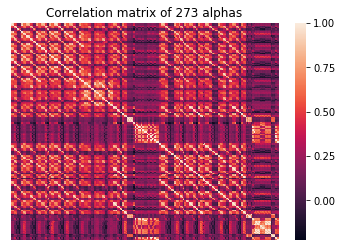

In [24]:
# Correlation matrix
corr = df_pnl_IS[alphas_high_sharpe].corr()
sns.heatmap(corr, annot = False, xticklabels=0,  yticklabels=0)
plt.title(f'Correlation matrix of {n_alphas_high_sharpe} alphas')
plt.show()

To choose maximum number of uncorrelated alphas, we use [Maximal clique algorithm](https://en.wikipedia.org/wiki/Clique_problem)

In [25]:
# Convert correlation matrix to graph
G = nx.from_pandas_adjacency(corr<CORRELATION_THRESHOLD)
# Find subset of uncorrelated alphas
alphas_high_sharpe_uncorr = list(clique.max_clique(G))
n_alphas_high_sharpe_uncorr = len(alphas_high_sharpe_uncorr)
print(f'Number of alphas with correlation < {CORRELATION_THRESHOLD} : {n_alphas_high_sharpe_uncorr}')

Number of alphas with correlation < 0.7 : 33


Now find merged PnL for all found uncorrelated alphas as mean of daily PnLs.<br>


In [26]:
# Merged PnL
df_pnl_merged = df_pnl[alphas_high_sharpe_uncorr].mean(axis = 1)

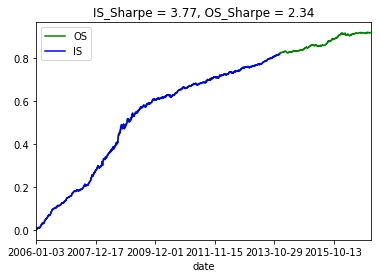

,Period,Start,End,Sharpe,"Drawdown, %","Positive days, %"
0,IS,2006-01-03,2014-01-01,3.766329,2.090097,62.151589
1,OS,2014-01-01,2016-12-30,2.341015,1.397494,56.770833


In [27]:
plot_pnl(df_pnl_merged, os_start = IS_END)
show_stats(df_pnl_merged, os_start = IS_END)

Now lets build portfolio using found alphas <br>
- Load all positions
- Find equal weighted sum of all positions
- Normalize positions to make absolute sum equal 1 every day


In [28]:
# Empty data_frame
df_portfolio = pd.DataFrame().reindex_like(data['r1']).replace(np.nan, 0)
# Load positions for all alphas  and sum it
for alpha in alphas_high_sharpe_uncorr:
    __ = pd.read_csv(pos_path + alpha + '.csv').set_index('date').replace(np.nan, 0)
    df_portfolio += __
# Normalize positions in portfolio
df_portfolio = market_normalize(validate(df_portfolio, valid_matrix = vm))

<b>Portfolio PnL and statistics.</b><br>

Results a bit differ compare to merged PnL because of netting effect

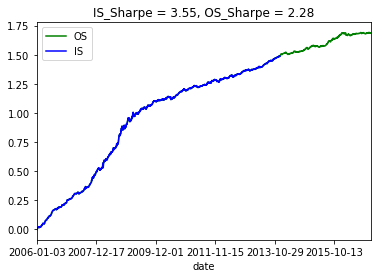

,Period,Start,End,Sharpe,"Drawdown, %","Positive days, %"
0,IS,2006-01-03,2014-01-01,3.551016,3.895251,61.90709
1,OS,2014-01-01,2016-12-30,2.284728,2.492353,57.03125


In [29]:
# Portfolio PnL ans statistics
portfolio_pnl = get_pnl(df_portfolio)
plot_pnl(portfolio_pnl, os_start = IS_END)
show_stats(portfolio_pnl, os_start = IS_END)

<h1> IV. Returns prediction

Now we can try to use alphas to predict tomorrow returns on Out-of-Sample period using following algorithm<br>

For each day of Out-of_samle:
1. For each alpha find tomorrow's expected pnl. For example, we can predict tomorrow pnl as 10-days moving average pnl.
2. Merge all alphas positions with expected pnls and build regression with alpha positions as features and expected pnl as target.
3. found coefficients of regression  - stocks returns predictions!
<br><br>
\begin{equation*}
\begin{bmatrix}
alpha_{1, t, 1} & alpha_{1, t, 2} & ... & alpha1_{1, t, M} \\
alpha_{2, t, 1} & alpha2_{2, t, 2} & ... & alpha2_{2, t, M} \\
... & ... & ... & ... \\
alpha_{N, t, 1} & alpha_{N, t, 2} & ... & alpha_{N, t, M} \\
\end{bmatrix} *
\begin{bmatrix}
return_{t+1, 1} \\
return_{t+1, 2} \\
...  \\
return_{t+1, M} \\
\end{bmatrix} =
\begin{bmatrix}
pnl_{t+1, 1} \\
pnl_{t+1, 2} \\
...  \\
pnl_{t+1, M} \\
\end{bmatrix}
\end{equation*}
<br><br>
More detail description of the algorithm: [(2017) Z.Kakushadze, W.Yu - Decoding Stock Market with Quant Alphas](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2965224) <br>

It the paper, simple linear regression was used. However, number of alphas N we have is much lesser then the number of instruments M.<br> But, according to paper, N sholud be much more then M. <br>
So, to avoid overfitting, I use Ridge regression instead.



In [30]:
# List of all availbale dates in OS period
OS_dates = data['r1'].index[data['r1'].index > IS_END]

In [31]:
# Load positions for all alphas for OS period
positions_list = []
for alpha in alphas_high_sharpe_uncorr:
    df_alpha_pos = pd.read_csv(pos_path + alpha + '.csv').set_index('date').loc[OS_dates].reset_index()
    df_alpha_pos['alpha_id'] = alpha
    df_alpha_pos = df_alpha_pos.set_index(['alpha_id', 'date'])
    positions_list.append(df_alpha_pos)
df_positions_OS = pd.concat(positions_list, axis = 0)

In [32]:
# For each day of OS find alpha pnl predictions
df_pnl_OS = df_pnl[alphas_high_sharpe_uncorr].rolling(window = 10).mean().shift(1)
df_pnl_OS = df_pnl_OS.loc[OS_dates].unstack()

In [33]:
# For each day in OS period find returns predictions
returns_predict_list = []
for current_day in OS_dates:
    pnl_current_day = df_pnl_OS[df_pnl_OS.index.get_level_values(1)==current_day]
    positions_current_day = df_positions_OS[df_positions_OS.index.get_level_values(1)==current_day]
    positions_current_day = positions_current_day.assign(pnl = pnl_current_day)
    positions_current_day = positions_current_day.dropna(axis = 1)
    # Regression
    X = positions_current_day.loc[:, positions_current_day.columns.drop('pnl')]
    y = positions_current_day['pnl']
#     clf = LinearRegression()
    clf = Ridge(alpha = 0.001)
    try:
        clf.fit(X, y)
    except:
        print(f'There are no positions in {current_day}')
        continue
    # Extract stocks returns predictions from regression coefficients
    y_predict = pd.DataFrame(list(zip(clf.coef_, positions_current_day.columns.drop('pnl'))), columns = ['r1_predict', 'id'])
    y_predict['date'] = current_day
    y_predict = y_predict.set_index(['id', 'date'])
    returns_predict_list.append(y_predict)
# Dataframe with predictions for OS period
df_returns_OS_predict = pd.concat(returns_predict_list)

There are no positions in 2014-06-02
There are no positions in 2014-07-04
There are no positions in 2014-12-26
There are no positions in 2014-12-30
There are no positions in 2015-03-31
There are no positions in 2015-06-30
There are no positions in 2015-07-03
There are no positions in 2015-11-27
There are no positions in 2015-12-30
There are no positions in 2016-01-18


In [34]:
# Dataframe with real returns for OS period
df_returns_OS_real = data['r1'][data['r1'].index.isin(OS_dates)].unstack().dropna().reset_index()
df_returns_OS_real = df_returns_OS_real.set_index(['id', 'date']).rename(columns = {0:'r1'})

# Concat real returns and predictons
df_returns_OS_all = pd.concat([df_returns_OS_real, df_returns_OS_predict], axis = 1).dropna()

Now lets plot real Realized returns vs Predicted returns

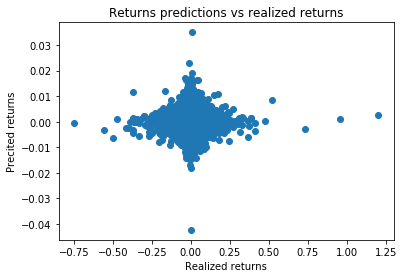

In [35]:
plt.plot(df_returns_OS_all['r1'].values, df_returns_OS_all['r1_predict'].values ,'o')
plt.xlabel('Realized returns')
plt.ylabel('Precited returns')
plt.title('Returns predictions vs realized returns')
plt.show()

Now when we found returns prediction, we can compare results with some benchamrk.<br>
As a metric of prediction error I choose MAE (Mean Absolute Error):<br>
\begin{equation*}
Mean Absolure Error = \frac{\sum_{t=1}^T\sum_{i=1}^M |r_{t+1,i} - r_{predicted, t,i}|}{ T * M}
\end{equation*}<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;<i>where T - number of days in OS; M - number of instruments in portfolio</i><br>


<br>
As the benchmark for the algoritm I choose simple model: prediction for tomorrow return equal today's return

In [36]:
r1_OS = data['r1'][data['r1'].index.isin(OS_dates)].unstack().dropna()
r0_OS = data['r0'][data['r0'].index.isin(OS_dates)].unstack().dropna()

In [37]:
MAE_benchmark = abs(r1_OS - r0_OS).mean()
print(f'Mean absolute error, benchmark = {MAE_benchmark}')

Mean absolute error, benchmark = 0.017710639538337018


In [38]:
MAE_model = abs(df_returns_OS_all['r1'] - df_returns_OS_all['r1_predict']).mean()
print(f'Mean absolute error, model = {MAE_model}')

Mean absolute error, model = 0.011424542516734863


Results: Returns predicted using alphas have lower MAE, comparing to the benchmark

<b>Finally</b>, lets build portfolio using predcited returns as weights.

In [39]:
# Normalize predicted returns to make sum of absolute weights = 1
df_returns_OS_all['r1_predict'] = df_returns_OS_all['r1_predict'].div(abs(df_returns_OS_all['r1_predict']).groupby('date').transform('sum'))

In [40]:
# Sum of weights = 1 every day
abs(df_returns_OS_all['r1_predict']).groupby('date').sum().head()

date
2014-01-02    1.0
2014-01-03    1.0
2014-01-06    1.0
2014-01-07    1.0
2014-01-08    1.0
Name: r1_predict, dtype: float64

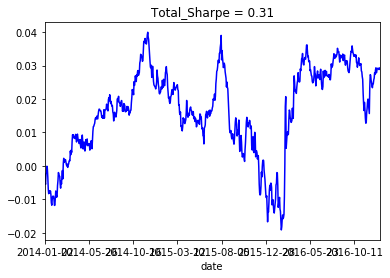

,Period,Start,End,Sharpe,"Drawdown, %","Positive days, %"
0,Total,2014-01-02,2016-12-30,0.313468,5.910499,51.451187


In [41]:
# Find PnL
df_pnl_result = (df_returns_OS_all['r1']*df_returns_OS_all['r1_predict']).groupby('date').sum()
plot_pnl(df_pnl_result)
show_stats(df_pnl_result)